In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import pickle
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

from ti import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv("./data/stocks_ti.csv")

df["DATE"] = pd.to_datetime(df['DATE'])

df.set_index("DATE", inplace=True)

df

,SPY_3M IMPLIED VOL,SPY_HIGH,SPY_LOW,SPY_OPEN,SPY_SHORT INTEREST RATIO,SPY_ewm_log_ret_13d,SPY_ewm_log_ret_1d,SPY_ewm_log_ret_21d,SPY_ewm_log_ret_3d,SPY_ewm_log_ret_5d,...,XRT_macd_sig,XRT_rsi,XRT_rsi_13d_slope,XRT_rsi_1d_slope,XRT_rsi_21d_slope,XRT_rsi_3d_slope,XRT_rsi_5d_slope,XRT_rsi_8d_slope,tweet_sentiment,news_sentiment
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-02,14.0384,0.006498,-0.006639,0.004078,1.507,0.005375,-0.000535,0.006782,-0.010765,-0.000939,...,0.598815,67.988107,19.826342,-7.838144,5.204016,-1.944891,7.252436,10.295799,-0.131934,0.075776
2015-01-05,14.1676,-0.005173,-0.020061,-0.006152,1.507,0.006181,-0.018225,0.003427,-0.019749,-0.011550,...,0.593092,59.339623,16.598506,-8.648484,-0.103102,-8.596080,-3.993711,0.899108,-0.102601,0.116118
2015-01-06,14.3399,0.004945,-0.014305,0.001833,1.507,0.006670,-0.009464,-0.000383,-0.023986,-0.022225,...,0.567309,53.461876,14.660032,-5.877747,-4.602641,-22.364376,-16.471123,-4.402835,0.025503,0.050569
2015-01-07,14.4772,0.014409,0.005291,0.007975,1.507,0.006085,0.012384,-0.002870,-0.019645,-0.023421,...,0.548476,67.244094,17.009353,13.782219,11.666405,-0.744013,-0.691608,6.508423,-0.051485,0.125229
2015-01-08,14.5777,0.018851,0.008270,0.008368,1.507,0.004606,0.017589,-0.002922,0.000432,-0.015031,...,0.544027,64.685908,12.113201,-2.558186,7.219379,5.346286,-11.140343,1.352575,0.100507,0.138343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,12.9785,0.000934,-0.000997,0.000778,2.463,0.021663,0.000031,0.028050,0.003051,0.008625,...,0.359009,67.779961,23.646861,-0.862487,24.291589,8.342875,14.908339,-0.857149,-0.048913,0.238482
2019-12-26,12.9736,0.005340,0.001276,0.001307,2.463,0.022183,0.005309,0.028235,0.004959,0.009226,...,0.380095,71.863118,22.659296,4.083157,26.104189,8.547421,17.008749,15.327685,0.195297,0.277311
2019-12-27,12.9749,0.002659,-0.002046,0.002474,2.463,0.023044,-0.000248,0.028175,0.005026,0.008180,...,0.403777,66.666667,15.808632,-5.196451,15.789474,-1.975781,7.229581,16.047198,0.027661,0.249240


In [4]:
df.columns[:30]

Index(['SPY_3M IMPLIED VOL', 'SPY_HIGH', 'SPY_LOW', 'SPY_OPEN',
       'SPY_SHORT INTEREST RATIO', 'SPY_ewm_log_ret_13d', 'SPY_ewm_log_ret_1d',
       'SPY_ewm_log_ret_21d', 'SPY_ewm_log_ret_3d', 'SPY_ewm_log_ret_5d',
       'SPY_ewm_log_ret_8d', 'SPY_ivol_13d_slope', 'SPY_ivol_1d_slope',
       'SPY_ivol_21d_slope', 'SPY_ivol_3d_slope', 'SPY_ivol_5d_slope',
       'SPY_ivol_8d_slope', 'SPY_log_ret_13d', 'SPY_log_ret_1d',
       'SPY_log_ret_21d', 'SPY_log_ret_3d', 'SPY_log_ret_5d', 'SPY_log_ret_8d',
       'SPY_macd', 'SPY_macd_13d_slope', 'SPY_macd_1d_slope',
       'SPY_macd_21d_slope', 'SPY_macd_3d_slope', 'SPY_macd_5d_slope',
       'SPY_macd_8d_slope'],
      dtype='object')

<Axes: xlabel='DATE'>

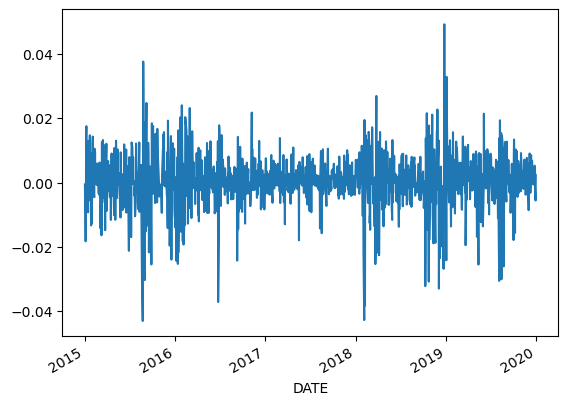

In [5]:
df['SPY_log_ret_1d'].plot()

# Functions

In [6]:
def prepare_X_y(X, y, lags_period, test_size=0.2):
    # Calculate split index
    split_idx = int(len(X) * (1 - test_size))

    # Split into training and testing sets based on the calculated index
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames for easier handling in later processes
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return (X_train_scaled, X_test_scaled, y_train, y_test)

In [56]:
# Function 3: Test MSE and R2
def test_mse_r2(model, X_test, y_test):
    """
    Calculates and prints the MSE and R^2 for the test set.
    
    Parameters:
    - model: The trained model to evaluate
    - X_test: Testing features
    - y_test: Testing target variable
    """
    predictions = model.predict(X_test)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, predictions, label='Predict')
    plt.legend()
    plt.show()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"MSE: {mse}, R^2: {r2}")

In [86]:
# Function 1: Train and Fit a Random Forest Model
def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    """
    Trains and fits a Random Forest model.
    
    Parameters:
    - X_train: Training features
    - y_train: Training target variable
    - n_estimators: The number of trees in the forest
    - max_depth: The maximum depth of the tree
    
    Returns:
    - A trained Random Forest model
    """
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function 2: Run Grid Search with Cross Validation
def run_grid_search(model, param_grid, X_train, y_train, n_splits=5):
    """
    Performs grid search with cross validation.
    
    Parameters:
    - model: The model for which the grid search is performed
    - param_grid: Dictionary with parameters names as keys and lists of parameter settings to try as values
    - X_train: Training features
    - y_train: Training target variable
    - n_splits: Number of splits for Time Series Split
    
    Returns:
    - The GridSearchCV instance after fitting
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1)
    gscv.fit(X_train, y_train)
    return gscv

# Set 1: only price and vol data ~ 1day log return

In [57]:
y = df['SPY_log_ret_1d'][1:]
X1 = df[['SPY_3M IMPLIED VOL', 'SPY_HIGH', 'SPY_LOW', 'SPY_OPEN',
       'SPY_SHORT INTEREST RATIO', 'SPY_ivol_13d_slope', 'SPY_ivol_1d_slope',
       'SPY_ivol_21d_slope', 'SPY_ivol_3d_slope', 'SPY_ivol_5d_slope',
       'SPY_ivol_8d_slope', 'SPY_log_ret_13d']][:-1]

(X_train1, X_test1, y_train1, y_test1) = prepare_X_y(X1, y, lags_period=None, test_size=0.2)

## Linear regression

In [58]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model with the training data
lr_model.fit(X_train1, y_train1)

# Coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Predict on the training data
y_train_pred = lr_model.predict(X_train1)

# Calculate metrics on training data
train_mse = mean_squared_error(y_train1, y_train_pred)
train_r2 = r2_score(y_train1, y_train_pred)

# Predict on the testing data
y_test_pred = lr_model.predict(X_test1)

# Calculate metrics on testing data
test_mse = mean_squared_error(y_test1, y_test_pred)
test_r2 = r2_score(y_test1, y_test_pred)

{
    "coefficients": coefficients,
    "intercept": intercept,
    "training_metrics": {"MSE": train_mse, "R2": train_r2},
    "testing_metrics": {"MSE": test_mse, "R2": test_r2},
}

{'coefficients': array([ 2.86368779e-04, -1.05328719e-03, -7.62732289e-04,  1.54815000e-03,
         1.63879340e-04, -2.82504463e-03, -1.77685149e-03,  4.37560998e-04,
         3.50534307e-03, -1.58872063e-03,  2.42322595e-03,  1.13101639e-05]),
 'intercept': 0.00018082125405848465,
 'training_metrics': {'MSE': 7.383392994798031e-05,
  'R2': 0.021884943800814183},
 'testing_metrics': {'MSE': 6.246252769480257e-05,
  'R2': -0.034361083514061974}}

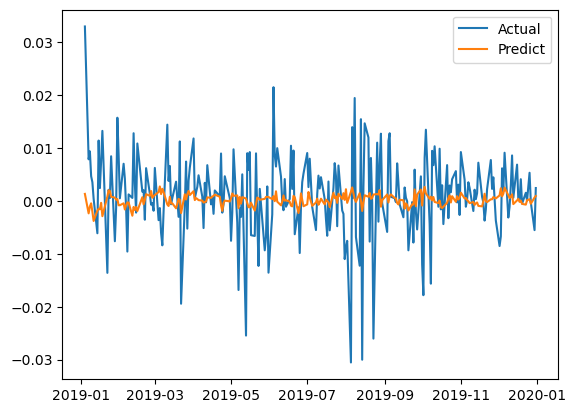

MSE: 6.246252769480257e-05, R^2: -0.034361083514061974


In [59]:
test_mse_r2(lr_model, X_test1, y_test1)

## Random Forest

In [67]:
model_rf1 = train_random_forest(X_train1, y_train1, n_estimators=100, max_depth=None)

# Perform Grid Search with Time Series Cross-Validation
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.15009362456818834


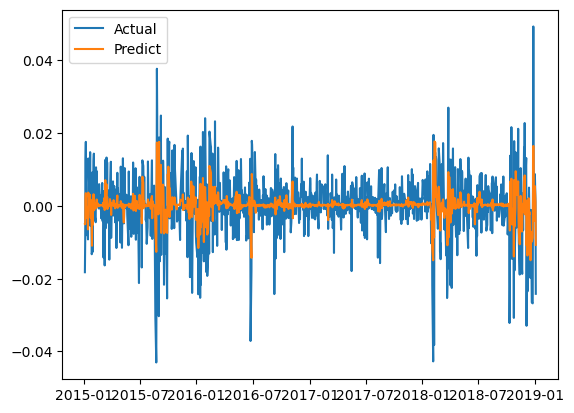

MSE: 4.4799155100036177e-05, R^2: 0.406523150816699


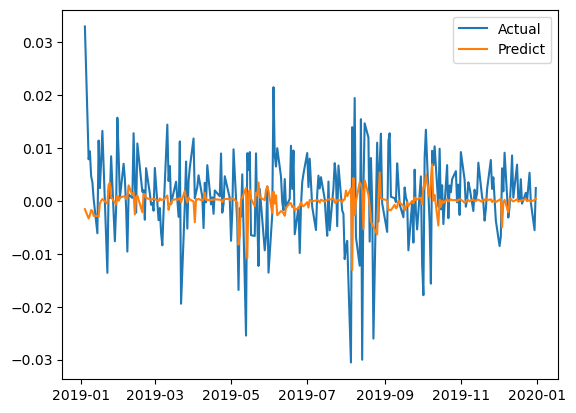

MSE: 6.823275772006243e-05, R^2: -0.12991439525667636


In [68]:
best_model_rf1 = run_grid_search(model_rf1, param_grid, X_train1, y_train1, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf1.best_params_}")
print(f"Best Score: {best_model_rf1.best_score_}")

test_mse_r2(best_model_rf1, X_train1, y_train1)

# Test MSE and R2 with the best model found
test_mse_r2(best_model_rf1, X_test1, y_test1)

## LSTM

In [30]:
import tensorflow as tf

# Check if TensorFlow can see the GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# Additional details about GPUs if available
for device in physical_devices:
    print(device)

if len(physical_devices) > 0:
    print("You can use GPU with TensorFlow for training your LSTM model.")
else:
    print("GPU not available. Training will default to CPU.")


Num GPUs Available:  0
GPU not available. Training will default to CPU.


In [23]:
def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape, dropout=dropout_rate),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def train_lstm_model(X_train, y_train, lstm_units=50, dropout_rate=0.2, epochs=100, batch_size=32, learning_rate=0.001):
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lstm_units=lstm_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    return model


In [24]:
def run_lstm_grid_search(build_model_fn, param_grid, X_train, y_train, n_splits=5):
    model = KerasRegressor(build_fn=build_model_fn, input_shape=(X_train.shape[1], X_train.shape[2]))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=1) # n_jobs is set to 1 for compatibility
    gscv.fit(X_train, y_train)
    return gscv


In [25]:
def test_mse_r2_lstm(model, X_test, y_test):
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, predictions, label='Predicted')
    plt.legend()
    plt.show()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"MSE: {mse}, R^2: {r2}")


In [26]:
param_grid_lstm = {
    'lstm_units': [50, 100, 150],  # Number of units in the LSTM layer
    'dropout_rate': [0.2, 0.3, 0.5],  # Dropout rate for regularization
    # You can also include learning rate if your build function supports it
    'learning_rate': [0.001, 0.01, 0.1]
}


In [27]:
time_steps = 1  # This is an example; the actual value depends on your dataset and problem
# Reshape X_train1 to have 3 dimensions
X_train1_reshaped = X_train1.values.reshape((X_train1.shape[0], time_steps, -1))
print(X_train1_reshaped.shape)
# Now X_train1_reshaped should have a shape similar to (num_samples, time_steps, features_per_step)

X_test1_reshaped = X_test1.values.reshape((X_test1.shape[0], time_steps, -1))

(999, 1, 12)


# Set 2: spy + ti (spy)

In [61]:
df.columns[23:38]

Index(['SPY_macd', 'SPY_macd_13d_slope', 'SPY_macd_1d_slope',
       'SPY_macd_21d_slope', 'SPY_macd_3d_slope', 'SPY_macd_5d_slope',
       'SPY_macd_8d_slope', 'SPY_macd_sig', 'SPY_rsi', 'SPY_rsi_13d_slope',
       'SPY_rsi_1d_slope', 'SPY_rsi_21d_slope', 'SPY_rsi_3d_slope',
       'SPY_rsi_5d_slope', 'SPY_rsi_8d_slope'],
      dtype='object')

In [62]:
y = df['SPY_log_ret_1d'][1:]

X2 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:38]], axis=1)[:-1]

(X_train2, X_test2, y_train2, y_test2) = prepare_X_y(X2, y, lags_period=None, test_size=0.2)

## Linear regression

In [63]:
# Initialize the Linear Regression model
lr_model2 = LinearRegression()

# Fit the model with the training data
lr_model2.fit(X_train2, y_train2)

# Coefficients and intercept
coefficients2 = lr_model2.coef_
intercept2 = lr_model2.intercept_

# Predict on the training data
y_train_pred2 = lr_model2.predict(X_train2)

# Calculate metrics on training data
train_mse2 = mean_squared_error(y_train2, y_train_pred2)
train_r22 = r2_score(y_train2, y_train_pred2)

# Predict on the testing data
y_test_pred2 = lr_model2.predict(X_test2)

# Calculate metrics on testing data
test_mse2 = mean_squared_error(y_test2, y_test_pred2)
test_r22 = r2_score(y_test2, y_test_pred2)

{
    "coefficients": coefficients2,
    "intercept": intercept2,
    "training_metrics": {"MSE": train_mse2, "R2": train_r22},
    "testing_metrics": {"MSE": test_mse2, "R2": test_r22},
}

{'coefficients': array([ 2.58706874e-04, -2.30054649e-03, -1.30079937e-03,  1.93579101e-03,
         6.23578365e-05,  1.26731240e-03,  2.27763033e-03, -1.35408315e-03,
        -1.75322615e-03, -5.13623828e-03,  3.10731449e-03,  1.95177554e-02,
        -4.12625417e-03, -1.81254937e-03,  1.13026980e-03,  2.32236198e-03,
         3.05133705e-03, -6.61936988e-03, -1.67635493e-02, -1.25519120e-04,
         6.64727215e-04,  1.60369230e-04, -3.01716596e-05,  3.68326359e-04,
         2.57153425e-04, -2.65680562e-04]),
 'intercept': 0.00018082125405848568,
 'training_metrics': {'MSE': 7.280107983371609e-05, 'R2': 0.0355676266577426},
 'testing_metrics': {'MSE': 6.370389367273192e-05, 'R2': -0.05491773892580465}}

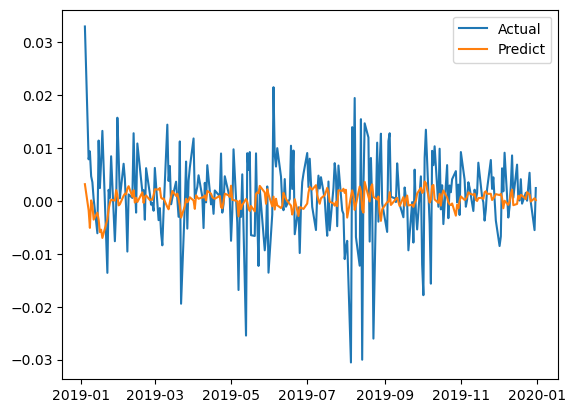

MSE: 6.370389367273192e-05, R^2: -0.05491773892580465


In [64]:
test_mse_r2(lr_model2, X_test2, y_test2)

## Random Forest

In [70]:
model_rf2 = train_random_forest(X_train2, y_train2, n_estimators=100, max_depth=None)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best Score: -0.12187430688180216


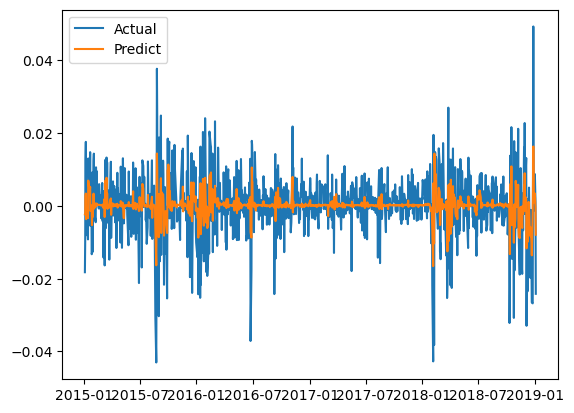

MSE: 4.429627834957552e-05, R^2: 0.4131850110398325


In [71]:
best_model_rf2 = run_grid_search(model_rf2, param_grid, X_train2, y_train2, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf2.best_params_}")
print(f"Best Score: {best_model_rf2.best_score_}")

test_mse_r2(best_model_rf2, X_train2, y_train2)

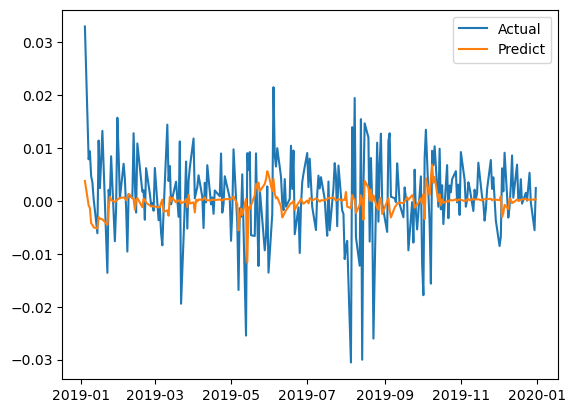

MSE: 6.334540959416221e-05, R^2: -0.04898134804287935


In [73]:
test_mse_r2(best_model_rf2, X_test2, y_test2)

# Set 3: spy + sector + ti (spy & sectors)

In [47]:
y = df['SPY_log_ret_1d'][1:]

X3 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:-2]], axis=1)[:-1].ffill()

(X_train3, X_test3, y_train3, y_test3) = prepare_X_y(X3, y, lags_period=None, test_size=0.2)

## Linear regression

In [49]:
# Initialize the Linear Regression model
lr_model3 = LinearRegression()

# Fit the model with the training data
lr_model3.fit(X_train3, y_train3)

# Coefficients and intercept
coefficients3 = lr_model3.coef_
intercept3 = lr_model3.intercept_

# Predict on the training data
y_train_pred3 = lr_model3.predict(X_train3)

# Calculate metrics on training data
train_mse3 = mean_squared_error(y_train3, y_train_pred3)
train_r23 = r2_score(y_train3, y_train_pred3)

# Predict on the testing data
y_test_pred3 = lr_model3.predict(X_test3)

# Calculate metrics on testing data
test_mse3 = mean_squared_error(y_test3, y_test_pred3)
test_r23 = r2_score(y_test3, y_test_pred3)

{
    "coefficients": coefficients2,
    "intercept": intercept2,
    "training_metrics": {"MSE": train_mse3, "R2": train_r23},
    "testing_metrics": {"MSE": test_mse3, "R2": test_r23},
}

{'coefficients': array([ 2.58706874e-04, -2.30054649e-03, -1.30079937e-03,  1.93579101e-03,
         6.23578365e-05,  1.26731240e-03,  2.27763033e-03, -1.35408315e-03,
        -1.75322615e-03, -5.13623828e-03,  3.10731449e-03,  1.95177554e-02,
        -4.12625417e-03, -1.81254937e-03,  1.13026980e-03,  2.32236198e-03,
         3.05133705e-03, -6.61936988e-03, -1.67635493e-02, -1.25519120e-04,
         6.64727215e-04,  1.60369230e-04, -3.01716596e-05,  3.68326359e-04,
         2.57153425e-04, -2.65680562e-04]),
 'intercept': 0.00018082125405848568,
 'training_metrics': {'MSE': 3.127515738864174e-05, 'R2': 0.5856823231760468},
 'testing_metrics': {'MSE': 0.0008102730508321959, 'R2': -12.417883357140752}}

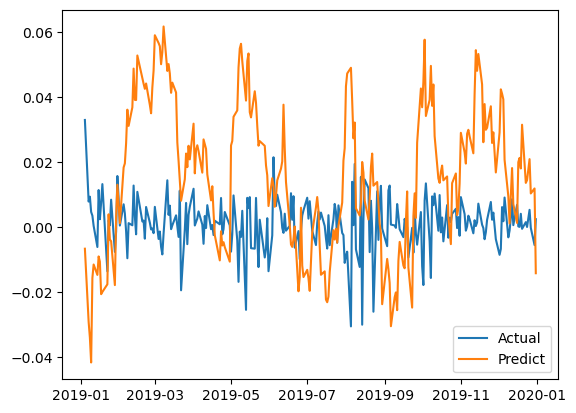

MSE: 0.0008102730508321959, R^2: -12.417883357140752


In [65]:
test_mse_r2(lr_model3, X_test3, y_test3)

# Random Forest

In [72]:
model_rf3 = train_random_forest(X_train3, y_train3, n_estimators=100, max_depth=None)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -0.10771849456992988


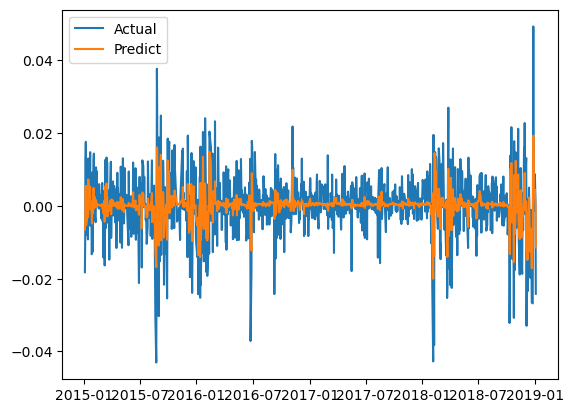

MSE: 3.646286966139263e-05, R^2: 0.5169580999797203


In [74]:
best_model_rf3 = run_grid_search(model_rf3, param_grid, X_train3, y_train3, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf3.best_params_}")
print(f"Best Score: {best_model_rf3.best_score_}")

test_mse_r2(best_model_rf3, X_train3, y_train3)

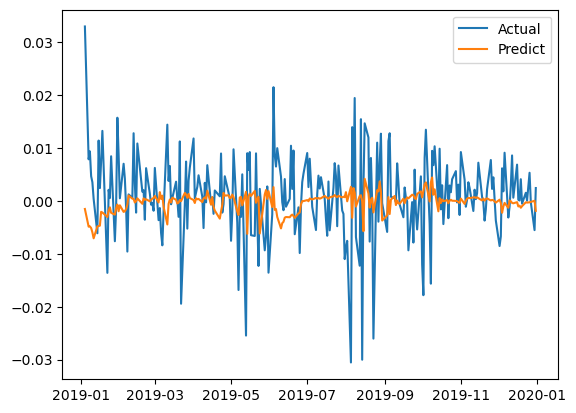

MSE: 6.780591446306916e-05, R^2: -0.12284599648883465


In [75]:
test_mse_r2(best_model_rf3, X_test3, y_test3)

# Set 4: All (including Tweet Sentiment and News Sentiment)

In [81]:
y = df['SPY_log_ret_1d'][1:]

X4 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:]], axis=1)[:-1].ffill()

(X_train4, X_test4, y_train4, y_test4) = prepare_X_y(X4, y, lags_period=None, test_size=0.2)

## Linear regression

In [82]:
# Initialize the Linear Regression model
lr_model4 = LinearRegression()

# Fit the model with the training data
lr_model4.fit(X_train4, y_train4)

# Coefficients and intercept
coefficients4 = lr_model4.coef_
intercept4 = lr_model4.intercept_

# Predict on the training data
y_train_pred4 = lr_model4.predict(X_train4)

# Calculate metrics on training data
train_mse4 = mean_squared_error(y_train4, y_train_pred4)
train_r24 = r2_score(y_train4, y_train_pred4)

# Predict on the testing data
y_test_pred4 = lr_model4.predict(X_test4)

# Calculate metrics on testing data
test_mse4 = mean_squared_error(y_test4, y_test_pred4)
test_r24 = r2_score(y_test4, y_test_pred4)

{
    "coefficients": coefficients4,
    "intercept": intercept4,
    "training_metrics": {"MSE": train_mse4, "R2": train_r24},
    "testing_metrics": {"MSE": test_mse4, "R2": test_r24},
}

{'coefficients': array([-4.94693399e-02, -4.52790492e-03, -1.71463475e-03,  5.42457441e-04,
         3.74214242e-03,  2.70466860e-01,  1.76882961e-02,  4.27874475e-02,
         1.75793471e-02,  1.00138154e-01, -1.35143203e-01,  4.56922005e-01,
        -2.01112030e-01, -6.32684940e-02,  1.19006364e-02, -6.30753569e-02,
        -1.55096702e-01,  1.66028528e-01, -6.81624391e-01, -4.01659435e-03,
         2.34808932e-03, -2.91782206e-03,  2.06501334e-03,  1.82309450e-03,
         5.13141182e-03,  5.21998019e-03, -2.00528917e-02, -3.60667252e-04,
         6.24919364e-04, -6.88519903e-04, -4.15027703e-03,  1.30811867e-03,
        -9.89236563e-04, -6.48986005e-03, -1.87484975e-02,  2.11202379e-03,
         1.00941521e-02, -5.72741937e-03,  1.38864106e-03,  8.60010309e-03,
         2.45366710e-04, -6.35575979e-03,  6.09443234e-03,  5.74426542e-03,
        -9.89236563e-04,  1.84295186e-03,  2.67011766e-03,  3.62334158e-04,
         5.53589512e-03,  9.31092647e-02, -1.43898498e-02, -1.81319893e-

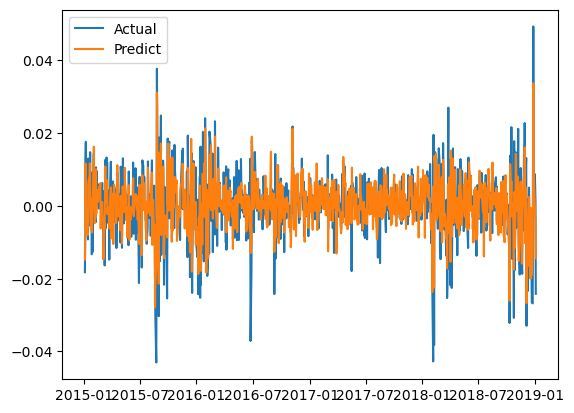

MSE: 3.1233926663793765e-05, R^2: 0.5862285272421209


In [85]:
test_mse_r2(lr_model4, X_train4, y_train4)

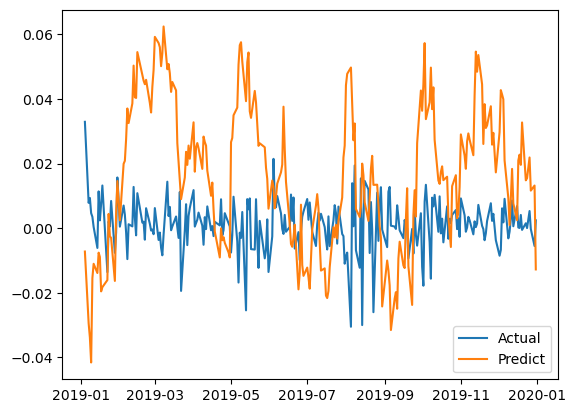

MSE: 0.000831179830559208, R^2: -12.764093479101948


In [84]:
test_mse_r2(lr_model4, X_test4, y_test4)

# Random Forest

In [ ]:
model_rf3 = train_random_forest(X_train3, y_train3, n_estimators=100, max_depth=None)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -0.10771849456992988


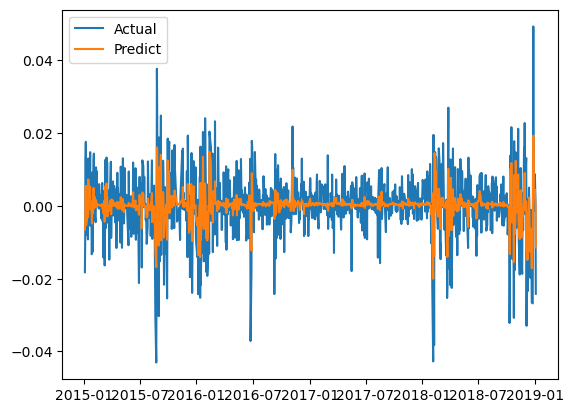

MSE: 3.646286966139263e-05, R^2: 0.5169580999797203


In [ ]:
best_model_rf3 = run_grid_search(model_rf3, param_grid, X_train3, y_train3, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf3.best_params_}")
print(f"Best Score: {best_model_rf3.best_score_}")

test_mse_r2(best_model_rf3, X_train3, y_train3)

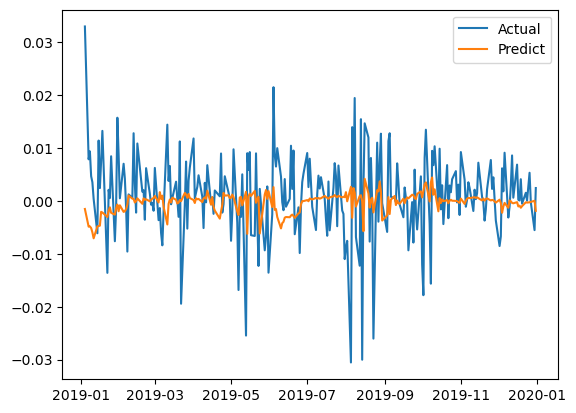

MSE: 6.780591446306916e-05, R^2: -0.12284599648883465


In [ ]:
test_mse_r2(best_model_rf3, X_test3, y_test3)